### Automated anomaly detection using PyOD and Auto-Sklearn
This notebook incorporates anomaly detection algorithms from PyOD into Auto-Sklearn. The following steps are followed:
- Auto-Sklearn is extended to incorporate PyOD algorithms
- Anomaly detection dataset(s) are imported and pre-processed
- Dataset is passed to Auto-Sklearn automl object for automated modeling and prediction
- Results and stats are obtained and analyzed

In [1]:
# Imports
import os, sys
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from scipy.io import arff
import sklearn.metrics
from sklearn.model_selection import train_test_split, PredefinedSplit, StratifiedShuffleSplit
from autosklearn.pipeline.components.classification import add_classifier
from autosklearn.classification import AutoSklearnClassifier
from autosklearn.metrics import roc_auc, average_precision
p = os.path.abspath('..')
sys.path.insert(1, p)
from utils import import_dataset, get_metric_result, add_pyod_models_to_pipeline
# Add models to Auto-Sklearn
add_pyod_models_to_pipeline()

Dataset: ../../data/Annthyroid_withoutdupl_norm_02_v01.arff
Fitting..
[WARNING] [2022-02-23 02:12:57,678:Client-autosklearn.automl_common.common.utils.backend] Directory /tmp/auto-sklearn_tmp_f5979c87-943c-11ec-a278-c8d9d2ea2351/.auto-sklearn/ensembles does not exist
auto-sklearn results:
  Dataset name: Annthyroid
  Metric: roc_auc
  Best validation score: 0.968171
  Number of target algorithm runs: 12
  Number of successful target algorithm runs: 8
  Number of crashed target algorithm runs: 0
  Number of target algorithms that exceeded the time limit: 4
  Number of target algorithms that exceeded the memory limit: 0

Dataset: ../../data/Annthyroid_withoutdupl_norm_05_v01.arff
Fitting..
[WARNING] [2022-02-23 02:15:52,133:Client-autosklearn.automl_common.common.utils.backend] Directory /tmp/auto-sklearn_tmp_5e2bf690-943d-11ec-a278-c8d9d2ea2351/.auto-sklearn/ensembles does not exist
auto-sklearn results:
  Dataset name: Annthyroid
  Metric: roc_auc
  Best validation score: 0.913883
  Nu

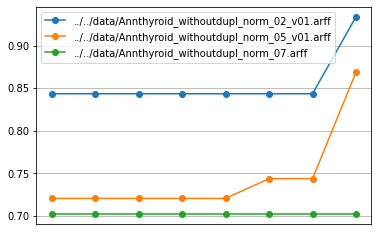

In [2]:
# Sample number
N = 5000
# Datasets
datasets = [
    '../../data/Annthyroid_withoutdupl_norm_02_v01.arff',
    '../../data/Annthyroid_withoutdupl_norm_05_v01.arff',
    '../../data/Annthyroid_withoutdupl_norm_07.arff'
]
# Init test performance
test_performance = pd.DataFrame()

# Loop
for dataset in datasets:
    print('Dataset:', dataset)
    # Import DataFrame
    df = import_dataset(dataset)
    if(len(df) > N):
        df = df.sample(n=N)
    # Extract X, y
    X  = df.iloc[:, :-1]
    y = df['outlier']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=10)

    # Method 1 - Predefined Split
    if False:
        # Pre-defined split indices for train and validation
        selected_indices = []
        sacrificed_outliers = 0 # count of outliers sampled for the training set
        for v in y_train:
            if v==1: # outlier
                if sacrificed_outliers>0:
                    selected_indices.append(1) # validation
                else:
                    selected_indices.append(-1) # training
                    sacrificed_outliers += 1 # will not be used for evaluation
            else:
                if np.random.rand()>0.8:
                    selected_indices.append(1) # validation
                else:
                    selected_indices.append(-1) # training
        # prints
        print('Number of total training samples:', len(y_train))
        print('Number of training samples:', selected_indices.count(-1))
        print('Number of validation samples:', selected_indices.count(1))
        print('Number of outliers:', sum(y_train))
        print('Number of outliers in the training split:', sacrificed_outliers)
        print('Number of outliers in the validation split:', sum(y_train) - sacrificed_outliers)

        resampling_strategy = PredefinedSplit(test_fold=selected_indices)

    # Method 2 - Stratified Shuffle Split
    resampling_strategy = StratifiedShuffleSplit(n_splits=1, test_size=0.25)

    # Build and fit a classifier
    automl = AutoSklearnClassifier(
        include = {
          'classifier': [
              'ABODClassifier',
              'CBLOFClassifier',
              'COPODClassifier',
              'ECODClassifier',
              'HBOSClassifier',
              'IForestClassifier',
              'KNNClassifier',
              'LMDDClassifier',
              'LOFClassifier',
              'MCDClassifier',
              'OCSVMClassifier',
              'PCAClassifier',
              'RODClassifier',
              'SOSClassifier'
          ],
          'feature_preprocessor': ["no_preprocessing"],
        },
        exclude = None,
        metric = roc_auc,
        scoring_functions = [roc_auc, average_precision],
        time_left_for_this_task = 180,
        per_run_time_limit = 20,
        ensemble_size = 0,
        initial_configurations_via_metalearning = 0,
        resampling_strategy = resampling_strategy,
        #delete_tmp_folder_after_terminate = False,
    )
    # Fit
    print('Fitting..')
    automl.fit(X_train, y_train, X_test, y_test, dataset_name='Annthyroid')

    # Print stats
    print(automl.sprint_statistics())
    #print(get_metric_result(automl.cv_results_).to_string(index=False))
    # Store test set performance
    test_performance[dataset] = automl.performance_over_time_[['Timestamp', 'single_best_test_score']].reset_index(drop=True)['single_best_test_score']

# Plot results
test_performance.fillna(method='ffill').plot(
    kind='line',
    legend=True,
    grid=True,
    marker='o'
)
plt.xticks([])
plt.savefig('annthyroid_stratified.png')
plt.show()